In [171]:
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
import datetime as dt
import numpy as np
import matplotlib.ticker as ticker


You are provided with daily historical sales data. The task is to forecast the total amount of products sold in every shop for the test set. Note that the list of shops and products slightly changes every month. Creating a robust model that can handle such situations is part of the challenge.


### File descriptions
* sales_train.csv - the training set. Daily historical data from January 2013 to October 2015.
* test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.
* sample_submission.csv - a sample submission file in the correct format.
* items.csv - supplemental information about the items/products.
* item_categories.csv  - supplemental information about the items categories.
* shops.csv- supplemental information about the shops.

### Data fields
* ID - an Id that represents a (Shop, Item) tuple within the test set
* shop_id - unique identifier of a shop
* item_id - unique identifier of a product
* item_category_id - unique identifier of item category
* item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
* item_price - current price of an item
* date - date in format dd/mm/yyyy
* date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
* item_name - name of item
* shop_name - name of shop
* item_category_name - name of item category

In [50]:
df=pd.read_csv('sales_train.csv.gz')

In [97]:
df.head()

,date_block_num,item_id,shop_id,month,year,item_price,item_cnt_month
0,0,19,25,1,2013,28.0,1
1,0,27,1,1,2013,1890.0,1
2,0,27,2,1,2013,2499.0,1
3,0,27,10,1,2013,1890.0,1
4,0,27,19,1,2013,2499.0,1


In [58]:
df['date']=pd.to_datetime(df['date'],dayfirst=True)

In [59]:
df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


#### let's add month and year columns to the data frame

In [60]:
df['month']=pd.DatetimeIndex(df['date']).month
df['year']=pd.DatetimeIndex(df['date']).year

In [61]:
df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,month,year
0,2013-01-02,0,59,22154,999.00,1.0,1,2013
1,2013-01-03,0,25,2552,899.00,1.0,1,2013
2,2013-01-05,0,25,2552,899.00,-1.0,1,2013
3,2013-01-06,0,25,2554,1709.05,1.0,1,2013
4,2013-01-15,0,25,2555,1099.00,1.0,1,2013


In [95]:
df1=pd.DataFrame(df.groupby(['date_block_num','item_id','shop_id','month','year'])['item_price'].mean()).reset_index()
df1['item_cnt_month']=pd.DataFrame(df.groupby(['date_block_num','item_id','shop_id','month','year'])['item_cnt_day'].count()).reset_index()['item_cnt_day']
df=df1.copy()

In [96]:
df.head()

,date_block_num,item_id,shop_id,month,year,item_price,item_cnt_month
0,0,19,25,1,2013,28.0,1
1,0,27,1,1,2013,1890.0,1
2,0,27,2,1,2013,2499.0,1
3,0,27,10,1,2013,1890.0,1
4,0,27,19,1,2013,2499.0,1


#### Let's assign an ID to the combination of item_id and shop_id. Be careful that this ID will be different from the test set.

In [129]:
df= df.assign(id=(df.item_id.astype(str) + '_' + df.shop_id.astype(str)).astype('category').cat.codes)


In [136]:
df.head()

,date_block_num,item_id,shop_id,month,year,item_price,item_cnt_month,id
0,0,19,25,1,2013,28.0,1,229301
1,0,27,1,1,2013,1890.0,1,280706
2,0,27,2,1,2013,2499.0,1,280715
3,0,27,10,1,2013,1890.0,1,280707
4,0,27,19,1,2013,2499.0,1,280714


In [140]:
df['id'].nunique()

424124

In [141]:
df.index.nunique()

1609124

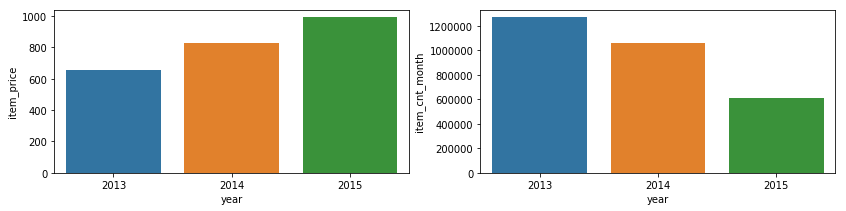

In [159]:
plt.figure(figsize=(14,3))
plt.subplot(121)
sns.barplot(df.groupby('year')['item_price'].mean().index,df.groupby('year')['item_price'].mean())
plt.subplot(122)
sns.barplot(df.groupby('year')['item_cnt_month'].sum().index,df.groupby('year')['item_cnt_month'].sum())

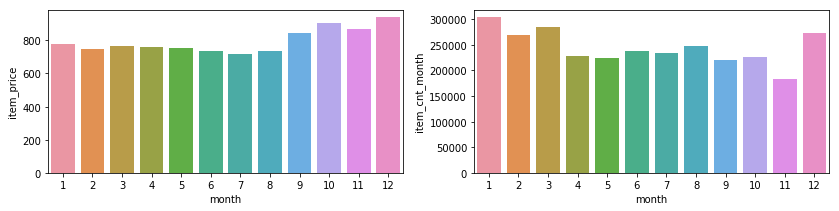

In [160]:
plt.figure(figsize=(14,3))
plt.subplot(121)
sns.barplot(df.groupby('month')['item_price'].mean().index,df.groupby('month')['item_price'].mean())
plt.subplot(122)
sns.barplot(df.groupby('month')['item_cnt_month'].sum().index,df.groupby('month')['item_cnt_month'].sum());

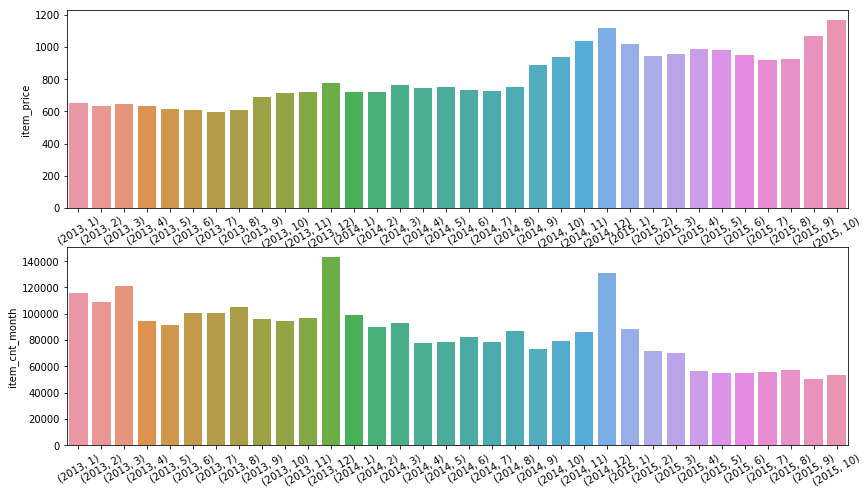

In [183]:
plt.figure(figsize=(14,8))
plt.subplot(211)
sns.barplot(df.groupby(['year','month'])['item_price'].mean().index,df.groupby(
    ['year','month'])['item_price'].mean())
plt.xticks(rotation=30)
plt.subplot(212)
sns.barplot(df.groupby(['year','month'])['item_cnt_month'].sum().index,df.groupby(
    ['year','month'])['item_cnt_month'].sum())
plt.xticks(rotation=30);

In [4]:
df_test=pd.read_csv('test.csv.gz')

In [5]:
df_test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [66]:
df_test['ID'].nunique()

214200

In [6]:
df_items=pd.read_csv('items.csv')

In [7]:
df_shops=pd.read_csv('shops.csv')

In [77]:
df_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
item_name           22170 non-null object
item_id             22170 non-null int64
item_category_id    22170 non-null int64
dtypes: int64(2), object(1)
memory usage: 519.7+ KB


In [78]:
df_shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [79]:
df_item_sum=pd.DataFrame(df.groupby(['date_block_num','item_id','item_price'])['item_cnt_day'].sum())

In [80]:
df_item_sum.reset_index(inplace=True)

In [81]:
df_item_sum.head()

,date_block_num,item_id,item_price,item_cnt_day
0,0,19,28.0,1.0
1,0,27,1890.0,2.0
2,0,27,2499.0,5.0
3,0,28,549.0,8.0
4,0,29,1890.0,1.0


In [82]:
y=df_item_sum.groupby('date_block_num')['item_cnt_day'].sum()
x=df_item_sum['date_block_num'].unique()

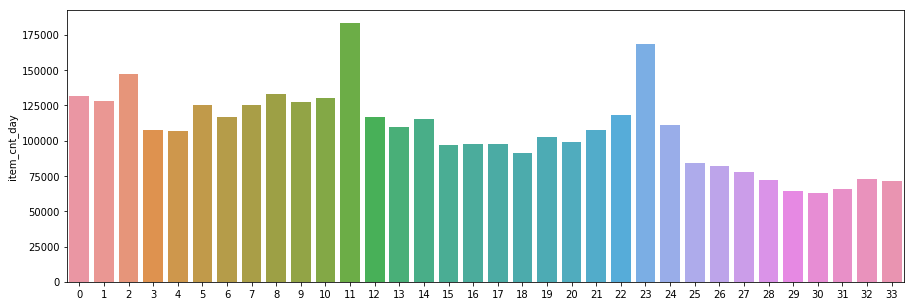

In [83]:
plt.figure(figsize=(15,5))
sns.barplot(x,y)

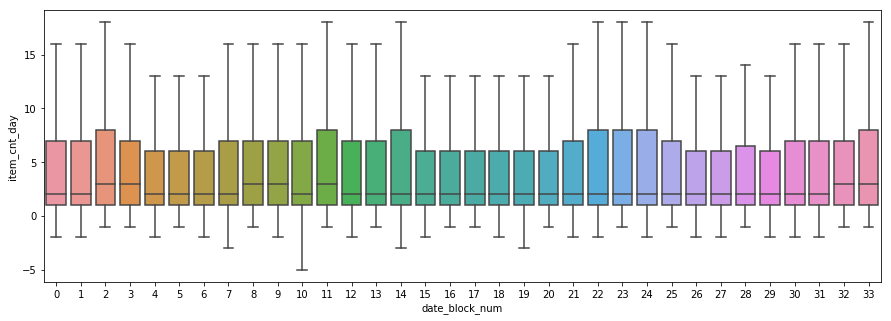

In [84]:
plt.figure(figsize=(15,5))
sns.boxplot(df_item_sum['date_block_num'],df_item_sum['item_cnt_day'],showfliers=False)

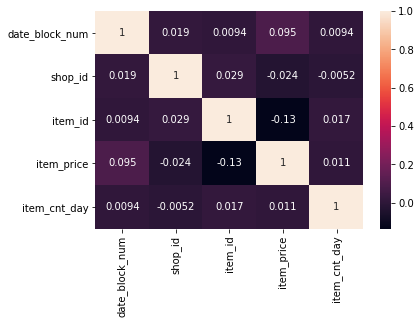

In [16]:
sns.heatmap(df.corr(),annot=True)

In [85]:
df['shop_id'].nunique()

60

In [86]:
pd.DataFrame(df.groupby(['date_block_num','item_id','shop_id','month','year'])['item_price'].count()).reset_index()

,date_block_num,item_id,shop_id,month,year,item_price
0,0,19,25,1,2013,1
1,0,27,1,1,2013,1
2,0,27,2,1,2013,1
3,0,27,10,1,2013,1
4,0,27,19,1,2013,1
5,0,27,26,1,2013,1
6,0,27,31,1,2013,1
7,0,27,45,1,2013,1
8,0,28,15,1,2013,1
9,0,28,31,1,2013,3


In [49]:
df

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,month,year
0,2013-02-01,0,59,22154,999.00,1.0,2,2013
1,2013-03-01,0,25,2552,899.00,1.0,3,2013
2,2013-05-01,0,25,2552,899.00,-1.0,5,2013
3,2013-06-01,0,25,2554,1709.05,1.0,6,2013
4,2013-01-15,0,25,2555,1099.00,1.0,1,2013
5,2013-10-01,0,25,2564,349.00,1.0,10,2013
6,2013-02-01,0,25,2565,549.00,1.0,2,2013
7,2013-04-01,0,25,2572,239.00,1.0,4,2013
8,2013-11-01,0,25,2572,299.00,1.0,11,2013
9,2013-03-01,0,25,2573,299.00,3.0,3,2013
